In [1]:
from shared.preface import *
import shared.functions as fct

### TODO: double check "beta" factor

In [2]:
# c = fct.c_vir(0, Mvir_NFW)
c = fct.c_vir(0, 3.76e12*Msun)
print(c)

16.758793969849247


### Values in Table 1 of Mertsch et al. (2020)

In [12]:
Rvir_Tab1 = fct.R_vir(0, Mvir_NFW)
print(Rvir_Tab1/kpc)
Rs_Tab1 = fct.scale_radius(0, Mvir_NFW)
print(Rs_Tab1/kpc)

334.5682089677852
19.96374020527414


### Critical density of universe.

In [9]:
rho_crit_today = fct.rho_crit(0)
rho_crit_today /= (h**2*Msun/Mpc**3)
print(f'{rho_crit_today:.2e} kg/m^3  <- this has to agree with literature') 

2.77e+11 kg/m^3  <- this has to agree with literature


### Time Variable s(z) and comparison to age of universe.

In [4]:
# In s_of_z function we use
H0_mod = H0/ (1/s)
print(H0_mod)

test_z = 1
s_val = fct.s_of_z(test_z)
print(f'Value of time variable s in seconds at redhshift {test_z}:','\n', s_val)
print('Age of universe in seconds:','\n', t0/s, 1/H0/s)

2.1840570317563187e-18
Value of time variable s in seconds at redhshift 1: 
 5.0931705102805286e+17
Age of universe in seconds: 
 4.3519679999999994e+17 4.578635014836795e+17


### Integrals for cosmic time

In [5]:
def t_integrand_a(a):

    # We need value of H0 in units of 1/s.
    H0_val = H0/(1/s)

    a_dot = np.sqrt(Omega_M/a**3 + Omega_L)*H0_val*a
    t_int = 1./a_dot

    return t_int

t, err = quad(t_integrand_a, 0, 1)
t_uni, err_uni = t, err
print(t_uni*s/Gyr, err_uni*s/Gyr)

13.85563294159454 2.0375443937087776e-12


In [6]:
def t_integrand_z(z):

    # We need value of H0 in units of 1/s.
    H0_val = H0/(1/s)

    a_dot = np.sqrt(Omega_M*(1.+z)**3 + Omega_L)*H0_val*(1.+z)
    t_int = 1./a_dot

    return t_int

t, err = quad(t_integrand_z, 0, np.inf)
t_uni, err_uni = t, err
print(t_uni*s/Gyr, err_uni*s/Gyr)

13.85563294159454 3.8804667681380017e-11


### Fermi-Dirac distribution

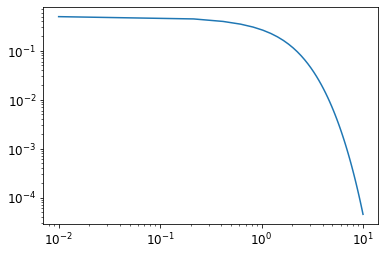

In [7]:
p_test_range = np.linspace(0.01, 10)*T_CNB
FD_range = fct.Fermi_Dirac(p_test_range)

plt.loglog(p_test_range/T_CNB, FD_range)
plt.show()

### Conversions between momentum and velocity (limits).

In [15]:
for m_eV in NU_MASSES:

    # Momentum limits (in units of T_CNB) to velocity limits (in km/s).
    v_lower = LOWER/m_eV / (km/s)
    v_upper = UPPER/m_eV / (km/s)
    print(v_lower, v_upper)

    # Velocity limits (in km/s) to momentum limits (in units of T_CNB).
    p_lower, y_lower = fct.u_to_p_eV(v_lower*(km/s)/(kpc/s), m_eV)
    p_upper, y_upper = fct.u_to_p_eV(v_upper*(km/s)/(kpc/s), m_eV)
    print(np.round(y_lower, 4), np.round(y_upper, 4), '\n')

50.376494697421776 50376.49469742177
0.01 10.0 

10.075298939484355 10075.298939484352
0.01 10.0 

5.037649469742178 5037.649469742176
0.01 10.0 

1.6792164899140594 1679.2164899140591
0.01 10.0 

